In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('datasets/prices.csv',
                parse_dates=['date'],
                index_col='date')
df.shape

(851264, 6)

In [3]:
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [4]:
df.dtypes

symbol     object
open      float64
close     float64
low       float64
high      float64
volume    float64
dtype: object

In [5]:
# Create new features from the time field
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['timestamp'] = df.index
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['dayofmonth'] = df['timestamp'].dt.day
    df['weekofyear'] = df['timestamp'].dt.weekofyear
    
    X = df[['open','hour','dayofweek','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [6]:
ibm = df.loc[df.symbol == 'IBM']

In [7]:
ibm.shape

(1762, 6)

In [8]:
ibm.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,IBM,131.179993,132.449997,130.850006,132.970001,6155300.0
2010-01-05,IBM,131.679993,130.850006,130.100006,131.850006,6841400.0
2010-01-06,IBM,130.679993,130.000000,129.809998,131.490005,5605300.0
2010-01-07,IBM,129.869995,129.550003,128.910004,130.250000,5840600.0
2010-01-08,IBM,129.070007,130.850006,129.050003,130.919998,4197200.0


In [9]:
TRAIN_SPLIT=1000
multi_data = ibm[['open', 'close']]
multi_data.head()

,open,close
date,,
2010-01-04,131.179993,132.449997
2010-01-05,131.679993,130.850006
2010-01-06,130.679993,130.000000
2010-01-07,129.869995,129.550003
2010-01-08,129.070007,130.850006


In [10]:
# Creating and splitting the data
multi_data_train = multi_data[:TRAIN_SPLIT]
multi_data_test = multi_data[TRAIN_SPLIT:]
X_train = create_features(multi_data_train)
y_train = multi_data_train['close']
X_test = create_features(multi_data_test)
y_test = multi_data_test['close']

<ipython-input-5-e87fec55d126>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = df.index
<ipython-input-5-e87fec55d126>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['timestamp'].dt.hour
<ipython-input-5-e87fec55d126>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [11]:
X_train.head()

,open,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2010-01-04,131.179993,0,0,1,2010,4,4,1
2010-01-05,131.679993,0,1,1,2010,5,5,1
2010-01-06,130.679993,0,2,1,2010,6,6,1
2010-01-07,129.869995,0,3,1,2010,7,7,1
2010-01-08,129.070007,0,4,1,2010,8,8,1


In [12]:
y_train.head()

date
2010-01-04    132.449997
2010-01-05    130.850006
2010-01-06    130.000000
2010-01-07    129.550003
2010-01-08    130.850006
Name: close, dtype: float64

In [13]:
X_test.head()

,open,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2013-12-23,181.050003,0,0,12,2013,357,23,52
2013-12-24,181.960007,0,1,12,2013,358,24,52
2013-12-26,183.559998,0,3,12,2013,360,26,52
2013-12-27,185.839996,0,4,12,2013,361,27,52
2013-12-30,185.320007,0,0,12,2013,364,30,1


In [14]:
y_test.head()

date
2013-12-23    182.229996
2013-12-24    183.220001
2013-12-26    185.350006
2013-12-27    185.080002
2013-12-30    186.410004
Name: close, dtype: float64

In [15]:
reg = xgb.XGBRegressor(n_estimators=1000, objective='reg:squarederror')
reg.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

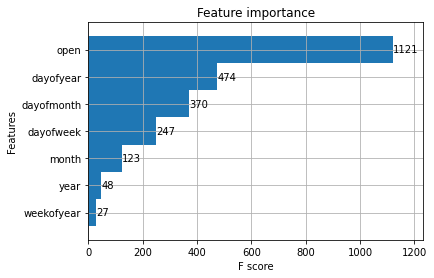

In [16]:
_= plot_importance(reg, height=1)

In [17]:
multi_data_test['Prediction'] = reg.predict(X_test)

<ipython-input-17-b71fc5982232>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_data_test['Prediction'] = reg.predict(X_test)


<AxesSubplot:xlabel='date'>

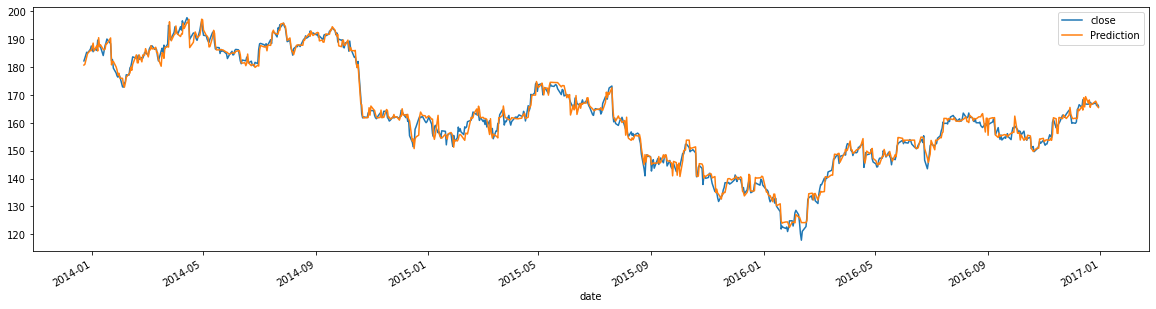

In [18]:
multi_data_test[['close','Prediction']].plot(figsize=(20, 5))

In [19]:
mean_squared_error(y_true=multi_data_test['close'],
                   y_pred=multi_data_test['Prediction'])

3.593379882675192

In [20]:
mean_absolute_error(y_true=multi_data_test['close'],    
                    y_pred=multi_data_test['Prediction'])

1.4516044048543617

In [21]:
rmse = np.sqrt(mean_squared_error(multi_data_test['close'], multi_data_test['Prediction']))
print(rmse)

1.8956212392445893


In [22]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
mean_absolute_percentage_error(y_true=y_test,    
                    y_pred=multi_data_test['Prediction'])

0.9130125775787935